# FOOTBALL AI

## Basic Installations


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


In [ ]:
!nvidia-smi

In [ ]:
!pip install -q gdown inference-gpu supervision


In [ ]:
!pip install -q git+https://github.com/roboflow/sports.git

In [ ]:
# # !gdown --id 1uhQOeZFWBOaveIy--eXVTKhDROputVkF -O input1.mp4
# !gdown --id 1prkerDkhpkRoua-F0MaRaXhhDPAQe8a9 -O input1.mp4
# # !gdown --id 19Ry-ImfxgEFYMHcFk5EkbnUrkZFJOnxK -O input3.mp4
# # !gdown --id 1HeFzQaFKZlXcXSYqW-AFMt3JVmhMiZTj -O input4.mp4
# # !gdown --id 1aczS1ErwZQPVViF4vs-ovpWw-lwBZInF -O input5.mp4

# !gdown -O "input2.mp4" "https://drive.google.com/uc?id=12TqauVZ9tLAv8kWxTTBFWtgt2hNQ4_ZF"
!gdown -O "input1.mp4" "https://drive.google.com/uc?id=19PGw55V8aA6GZu5-Aac5_9mCy3fNxmEf"
# !gdown -O "input3.mp4" "https://drive.google.com/uc?id=1OG8K6wqUw9t7lp9ms1M48DxRhwTYciK-"
# !gdown -O "input4.mp4" "https://drive.google.com/uc?id=1yYPKuXbHsCxqjA9G-S6aeR2Kcnos8RPU"
# !gdown -O "input5.mp4" "https://drive.google.com/uc?id=1vVwjW1dE1drIdd4ZSILfbCGPD4weoNiu"


In [ ]:
import os
os.environ["ONXXRUNTIME_EXECUTION_PROVIDERS"] = "[CUDAExecutionProvider]"

## Ball Player Goalkeeper and Referee Detection

In [ ]:
from inference import get_model
from google.colab import userdata
ROBOFLOW_API_KEY = userdata.get('ROBOFLOW_API_KEY')
Player_detection_model_id = "football-ai-mfjz2/2"
Player_detection_model = get_model(
    model_id=Player_detection_model_id,
    api_key=ROBOFLOW_API_KEY,

)


In [ ]:
import cv2
import supervision as sv
from tqdm import tqdm

Ball_id = 0;
Goalkeeper_id = 1;
Player_id = 2;
Referee_id = 3;

# Load Video
Source_video_path = "/content/input1.mp4"
target_path = "/content/Outputs/Player_detection.mp4"


ellipse_annotator = sv.EllipseAnnotator(
    color = sv.ColorPalette.from_hex(['#00BFFF','#FF1493','#FFD700']),
    thickness = 2
)


triangle_annotator = sv.TriangleAnnotator(
    color = sv.ColorPalette.from_hex(['#FFD700']),
    base = 20,
    height = 17 ,
)

label_annotator = sv.LabelAnnotator(
    color = sv.ColorPalette.from_hex(['#00BFFF','#FF1493','#FFD700']),
    text_color = sv.ColorPalette.from_hex(['#000000']),
    text_position = sv.Position.BOTTOM_CENTER,
)

tracker = sv.ByteTrack()
tracker.reset()

frame_generator = sv.get_video_frames_generator(Source_video_path)
frame = next(frame_generator)

video_info = sv.VideoInfo.from_video_path(Source_video_path)
video_sink = sv.VideoSink(target_path=target_path,video_info=video_info)

with video_sink:
    for frame in tqdm(frame_generator,total=video_info.total_frames,desc='Processing the Video'):

        result = Player_detection_model.infer(frame, confidence=0.30)[0]
        detections = sv.Detections.from_inference(result)

        # Separating ball detections from others and tracking them
        ball_detections = detections[detections.class_id == Ball_id]
        ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

        all_detections = detections[detections.class_id != Ball_id]
        all_detections = tracker.update_with_detections(all_detections)
        all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
        all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
        all_detections.class_id = all_detections.class_id.astype(int)

        # Labeling Players and Referees with Tracker_ID
        labels = [
            f"{class_name} {confidence:.2f}"
            for class_name, confidence in zip(all_detections['class_name'],all_detections.confidence)
        ]


        # Annotating the frames (Elliptical for Players and Referee , Triangular for Ball)
        annotated_frame = frame.copy()
        annotated_frame = ellipse_annotator.annotate(annotated_frame, all_detections)
        annotated_frame = triangle_annotator.annotate(annotated_frame, ball_detections)
        annotated_frame = label_annotator.annotate(annotated_frame, detections=all_detections, labels=labels)

        video_sink.write_frame(annotated_frame)


## Classification of Players into two teams using Siglip and UMAP

In [ ]:
import cv2
import supervision as sv
from tqdm import tqdm

Ball_id = 0;
Goalkeeper_id = 1;
Player_id = 2;
Referee_id = 3;

# Load Video
Source_video_path = "/content/input1.mp4"

from tqdm import tqdm
Stride = 30
Player_class = 2
def extract_player_crops(Source_video_path:str):
    frame_generator = sv.get_video_frames_generator(Source_video_path,stride = Stride)

    crops = []
    for frame in tqdm(frame_generator):
        result = Player_detection_model.infer(frame, confidence=0.50)[0]
        detections = sv.Detections.from_inference(result)
        detections = detections.with_nms(threshold=0.5,class_agnostic=True)
        player_detections = detections[detections.class_id==Player_class]
        crops += [
            sv.crop_image(frame,xyxy)
            for xyxy
            in player_detections.xyxy
        ]
    return crops

# crops = extract_player_crops(Source_video_path)

In [ ]:
import torch
from transformers import AutoProcessor , SiglipVisionModel

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SiglipModelPath = 'google/siglip-base-patch16-224'
processor = AutoProcessor.from_pretrained(SiglipModelPath)
model = SiglipVisionModel.from_pretrained(SiglipModelPath)

In [ ]:
from more_itertools import chunked
import numpy as np
import torch
from tqdm import tqdm

Batch_size = 32

crops = [sv.cv2_to_pillow(np.asarray(crop, dtype=np.uint8)) for crop in crops ]

batches = chunked(crops, n=Batch_size)
data = []

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(DEVICE)

with torch.no_grad():
    for batch in tqdm(batches, desc="Generating embeddings"):
        inputs = processor(images=batch, return_tensors="pt").to(DEVICE)  # Ensure inputs match model device
        outputs = model(**inputs)
        embeddings = torch.mean(outputs.last_hidden_state, dim=1).cpu().numpy()  # Move output to CPU before NumPy conversion
        data.append(embeddings)

data = np.concatenate(data) # size will be N*768


In [ ]:
import umap
from sklearn.cluster import KMeans

Reducer = umap.UMAP(n_components=3)
Cluster_model = KMeans(n_clusters=2)

projections = Reducer.fit_transform(data) # size will be N*3
labels = Cluster_model.fit_predict(projections)

In [ ]:
team_0 = [
    crop
    for crop, label
    in zip(crops, labels)
    if label == 0
]

team_1 = [
    crop
    for crop, label
    in zip(crops, labels)
    if label == 1
]

print("Crops")
sv.plot_images_grid(crops[:100],grid_size=(10,10))
print("Team 0")
sv.plot_images_grid(team_0[:100],grid_size=(10,10))
print("Team 1")
sv.plot_images_grid(team_1[:100],grid_size=(10,10))


In [ ]:
import numpy as np
import supervision as sv

def resolve_goalie_team_id(
    Player_detctions: sv.Detections,
    goalkeeper_detctions: sv.Detections,
):
    goalie_xy = goalkeeper_detctions.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    player_xy = Player_detctions.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)

    # Handle cases with no player detections for each team
    if len(player_xy[Player_detctions.class_id == 0]) == 0:
        team_0_centroid = np.array([0, 0])  # Or some default value
    else:
        team_0_centroid = player_xy[Player_detctions.class_id == 0].mean(axis=0)

    if len(player_xy[Player_detctions.class_id == 1]) == 0:
        team_1_centroid = np.array([0, 0])  # Or some default value
    else:
        team_1_centroid = player_xy[Player_detctions.class_id == 1].mean(axis=0)

    goalie_team_ids = []
    for goalie_point in goalie_xy:
        dist_0 = np.linalg.norm(goalie_point - team_0_centroid)
        dist_1 = np.linalg.norm(goalie_point - team_1_centroid)
        goalie_team_ids.append(0 if dist_0 < dist_1 else 1)

    # Ensure goalie_team_ids is a NumPy array and handle empty case
    goalie_team_ids = np.array(goalie_team_ids)
    if goalie_team_ids.shape == ():
        goalie_team_ids = goalie_team_ids.reshape((0,))

    return goalie_team_ids

In [ ]:
import cv2
import supervision as sv
from tqdm import tqdm
from sports.common.team import TeamClassifier

Ball_id = 0;
Goalkeeper_id = 1;
Player_id = 2;
Referee_id = 3;

# Load Video
Source_video_path = "/content/input1.mp4"
target_path = "/content/Outputs/Team_classifier.mp4"


crops = extract_player_crops(Source_video_path)
team_classifier = TeamClassifier(device=DEVICE)
team_classifier.fit(crops)


ellipse_annotator = sv.EllipseAnnotator(
    color = sv.ColorPalette.from_hex(['#00BFFF','#FF1493','#FFD700']),
    thickness = 2
)


triangle_annotator = sv.TriangleAnnotator(
    color = sv.ColorPalette.from_hex(['#FFD700']),
    base = 20,
    height = 17 ,
)

label_annotator = sv.LabelAnnotator(
    color = sv.ColorPalette.from_hex(['#00BFFF','#FF1493','#FFD700']),
    text_color = sv.ColorPalette.from_hex(['#000000']),
    text_position = sv.Position.BOTTOM_CENTER,
)

tracker = sv.ByteTrack()
tracker.reset()

frame_generator = sv.get_video_frames_generator(Source_video_path)
frame = next(frame_generator)

video_info = sv.VideoInfo.from_video_path(Source_video_path)
video_sink = sv.VideoSink(target_path=target_path,video_info=video_info)

with video_sink:
    for frame in tqdm(frame_generator,total=video_info.total_frames,desc='Processing the Video'):

        result = Player_detection_model.infer(frame, confidence=0.30)[0]
        detections = sv.Detections.from_inference(result)

        # Separating ball detections from others and tracking them
        ball_detections = detections[detections.class_id == Ball_id]
        all_detections = detections[detections.class_id != Ball_id]
        ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)
        all_detections = tracker.update_with_detections(all_detections)
        all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)

        # Divide players and goalkeepers into teams
        player_detections = all_detections[all_detections.class_id == Player_id]
        player_crops = [
            sv.crop_image(frame, xyxy) for xyxy in player_detections.xyxy if xyxy is not None
        ]
        player_detections.class_id = team_classifier.predict(player_crops)
        goalkeeper_detections = all_detections[all_detections.class_id == Goalkeeper_id]
        goalkeeper_detections.class_id = resolve_goalie_team_id(player_detections, goalkeeper_detections)
        referee_detections = all_detections[all_detections.class_id == Referee_id]
        referee_detections.class_id -= 1
        all_detections = sv.Detections.merge([player_detections, goalkeeper_detections, referee_detections])
        all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
        all_detections.class_id = all_detections.class_id.astype(int)

        # Labeling Players and Referees with Tracker_ID
        labels = [
                    f"#{tracker_id}"
                    for tracker_id
                    in all_detections.tracker_id
        ]

        # Annotating the frames (Elliptical for Players and Referee , Triangular for Ball)
        annotated_frame = frame.copy()
        annotated_frame = ellipse_annotator.annotate(annotated_frame, all_detections)
        annotated_frame = triangle_annotator.annotate(annotated_frame, ball_detections)
        annotated_frame = label_annotator.annotate(annotated_frame, detections=all_detections, labels=labels)


        video_sink.write_frame(annotated_frame)


## Key Point Detection

In [ ]:
Key_point_detection_id = "football-field-detection-radku/1"
Key_point_detection_model = get_model(
    model_id=Key_point_detection_id,
    api_key=ROBOFLOW_API_KEY,
)

In [ ]:
vertex_annotator = sv.VertexAnnotator(
    color=sv.Color.from_hex('#FF1493'),
    radius = 8
)

frame_generator = sv.get_video_frames_generator(Source_video_path)
frame = next(frame_generator)
result = Key_point_detection_model.infer(frame, confidence=0.50)[0]
key_points = sv.KeyPoints.from_inference(result)

annotated_frame = frame.copy()
annotated_frame = vertex_annotator.annotate(annotated_frame, key_points)
sv.plot_image(annotated_frame)

In [ ]:
from sports.configs.soccer import SoccerPitchConfiguration
Config = SoccerPitchConfiguration()

In [ ]:
from sports.annotators.soccer import draw_pitch

annotated_frame = draw_pitch( Config)
sv.plot_image(annotated_frame)

In [ ]:
import numpy as np
import cv2

class ViewTransformer:

    def __init__(self, source: np.ndarray, target: np.ndarray):
        source = source.astype(np.float32)
        target = target.astype(np.float32)
        self.m, _ = cv2.findHomography(source, target)

    def transform_points(self, points: np.ndarray) -> np.ndarray:
        # Check if points is None or empty
        if points is None or points.size == 0:
            return points  # or return an empty array: return np.empty((0, 2), dtype=np.float32)

        points = points.reshape(-1, 1, 2).astype(np.float32)
        points = cv2.perspectiveTransform(points, self.m)
        return points.reshape(-1, 2).astype(np.float32)

In [ ]:
import cv2
import supervision as sv
from tqdm import tqdm
from sports.common.team import TeamClassifier

Ball_id = 0;
Goalkeeper_id = 1;
Player_id = 2;
Referee_id = 3;

# Load Video
Source_video_path = "/content/input1.mp4"
target_path = "/content/Outputs/Key_point_detection.mp4"

vertex_annotator = sv.VertexAnnotator(
    color=sv.Color.from_hex('#FF1493'),
    radius = 8
)

edge_annotator = sv.EdgeAnnotator(
    color=sv.Color.from_hex('#00BFFF'),
    thickness = 2,
    edges = Config.edges
)

frame_generator = sv.get_video_frames_generator(Source_video_path)
frame = next(frame_generator)

video_info = sv.VideoInfo.from_video_path(Source_video_path)
video_sink = sv.VideoSink(target_path=target_path,video_info=video_info)

with video_sink:
  for frame in tqdm(frame_generator,desc='Processing the video',total=video_info.total_frames):
      result = Key_point_detection_model.infer(frame, confidence=0.30)[0]
      key_points = sv.KeyPoints.from_inference(result)

      filter = key_points.confidence[0] > 0.5
      frame_reference_points = key_points.xy[0][filter]
      frame_refernce_key_points = sv.KeyPoints(xy=frame_reference_points[np.newaxis,...])
      pitch_reference_points = np.array(Config.vertices)[filter]

      view_transformer = ViewTransformer(
          source = pitch_reference_points,
          target = frame_reference_points
      )

      pitch_all_points = np.array(Config.vertices)
      frame_all_points = view_transformer.transform_points(pitch_all_points)
      frame_all_key_points = sv.KeyPoints(xy=frame_all_points[np.newaxis,...])

      annotated_frame = frame.copy()
      annotated_frame = edge_annotator.annotate(annotated_frame, frame_all_key_points)
      annotated_frame = vertex_annotator.annotate(annotated_frame, key_points)
      # sv.plot_image(annotated_frame)
      video_sink.write_frame(annotated_frame)

## Radar View of Players , Ball and Referee

In [ ]:
import supervision as sv
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
from sports.common.team import TeamClassifier
from sports.annotators.soccer import draw_pitch, draw_points_on_pitch
from PIL import Image
from io import BytesIO

# Object IDs
Ball_id = 0
Goalkeeper_id = 1
Player_id = 2
Referee_id = 3

# Load Video
Source_video_path = "/content/input1.mp4"
target_path = "/content/Outputs/Radar_view.mp4"

crops = extract_player_crops(Source_video_path)
team_classifier = TeamClassifier(device=DEVICE)
team_classifier.fit(crops)

tracker = sv.ByteTrack()
tracker.reset()

frame_generator = sv.get_video_frames_generator(Source_video_path)
video_info = sv.VideoInfo.from_video_path(Source_video_path)
video_sink = sv.VideoSink(target_path=target_path, video_info=video_info)

with video_sink:
    for frame in tqdm(frame_generator, total=video_info.total_frames, desc='Processing Video'):

        result = Player_detection_model.infer(frame, confidence=0.30)[0]
        detections = sv.Detections.from_inference(result)

        # Separating ball detections from others and tracking them
        ball_detections = detections[detections.class_id == Ball_id]
        all_detections = detections[detections.class_id != Ball_id]
        ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)
        all_detections = tracker.update_with_detections(all_detections)
        all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)

        # Divide players and goalkeepers into teams
        player_detections = all_detections[all_detections.class_id == Player_id]
        referee_detections = all_detections[all_detections.class_id == Referee_id]
        goalkeeper_detections = all_detections[all_detections.class_id == Goalkeeper_id]

        player_crops = [sv.crop_image(frame, xyxy) for xyxy in player_detections.xyxy]
        player_detections.class_id = team_classifier.predict(player_crops)

        goalkeeper_detections.class_id = resolve_goalie_team_id(player_detections, goalkeeper_detections)

        result = Key_point_detection_model.infer(frame, confidence=0.30)[0]
        key_points = sv.KeyPoints.from_inference(result)

        filter = key_points.confidence[0] > 0.5
        frame_reference_points = key_points.xy[0][filter]
        frame_refernce_key_points = sv.KeyPoints(xy=frame_reference_points[np.newaxis, ...])
        pitch_reference_points = np.array(Config.vertices)[filter]

        view_transformer = ViewTransformer(
            source=frame_reference_points,
            target=pitch_reference_points
        )

        frame_ball_xy = ball_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
        pitch_ball_xy = view_transformer.transform_points(frame_ball_xy)

        frame_players_xy = player_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
        pitch_players_xy = view_transformer.transform_points(frame_players_xy)

        frame_goalkeepers_xy = goalkeeper_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
        if frame_goalkeepers_xy is not None:
            pitch_goalkeepers_xy = view_transformer.transform_points(frame_goalkeepers_xy)
        else:
            pitch_goalkeepers_xy = None

        frame_referees_xy = referee_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
        pitch_referees_xy = view_transformer.transform_points(frame_referees_xy)

        pitch = draw_pitch(Config)  # Remove the ax argument
        fig, ax = plt.subplots(figsize=(13, 8))
        ax.imshow(pitch)
        pitch = draw_points_on_pitch(
            config=Config,
            xy=pitch_ball_xy,
            face_color=sv.Color.BLACK,
            edge_color=sv.Color.BLACK,
            radius=10,
            pitch=pitch
        )

        pitch = draw_points_on_pitch(
            config=Config,
            xy=pitch_players_xy[player_detections.class_id == 0],
            face_color=sv.Color.from_hex('#00BFFF'),
            edge_color=sv.Color.BLACK,
            radius=10,
            pitch=pitch
        )

        pitch = draw_points_on_pitch(
            config=Config,
            xy=pitch_players_xy[player_detections.class_id == 1],
            face_color=sv.Color.from_hex('#FF1493'),
            edge_color=sv.Color.BLACK,
            radius=10,
            pitch=pitch
        )

        pitch = draw_points_on_pitch(
            config=Config,
            xy=pitch_goalkeepers_xy[goalkeeper_detections.class_id == 0],
            face_color=sv.Color.from_hex('#00BFFF'),
            edge_color=sv.Color.BLACK,
            radius=10,
            pitch=pitch
        )

        pitch = draw_points_on_pitch(
            config=Config,
            xy=pitch_goalkeepers_xy[goalkeeper_detections.class_id == 1],
            face_color=sv.Color.from_hex('#FF1493'),
            edge_color=sv.Color.BLACK,
            radius=10,
            pitch=pitch
        )

        pitch = draw_points_on_pitch(
            config=Config,
            xy=pitch_referees_xy,
            face_color=sv.Color.from_hex('#FFD700'),
            edge_color=sv.Color.BLACK,
            radius=10,
            pitch=pitch
        )

        # Convert Matplotlib figure to NumPy array
        buf = BytesIO()
        fig.savefig(buf, format="png", bbox_inches="tight", pad_inches=0) # Save the figure
        buf.seek(0)
        plt.close(fig)

        img = Image.open(buf)
        radar_frame = np.array(img)

        # Convert RGBA to RGB (if needed)
        if radar_frame.shape[-1] == 4:
            radar_frame = cv2.cvtColor(radar_frame, cv2.COLOR_RGBA2RGB)

        # Write processed frame to video
        video_sink.write_frame(radar_frame)


## Player Detection & Radar View

In [ ]:
import supervision as sv
import torch
import cv2
import numpy as np
from tqdm import tqdm
from sports.common.team import TeamClassifier
from sports.annotators.soccer import draw_pitch, draw_points_on_pitch
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Define IDs
Ball_id, Goalkeeper_id, Player_id, Referee_id = 0, 1, 2, 3

# Initialize video processing
Source_video_path = "/content/input1.mp4"
target_path = "/content/Outputs/Player_Detection&Radar_view.mp4"
video_info = sv.VideoInfo.from_video_path(Source_video_path)
video_sink = sv.VideoSink(target_path=target_path, video_info=video_info)

# Load team classifier
crops = extract_player_crops(Source_video_path)
team_classifier = TeamClassifier(device=DEVICE)
team_classifier.fit(crops)

# Initialize tracker
tracker = sv.ByteTrack()
tracker.reset()

# Get video frames
frame_generator = sv.get_video_frames_generator(Source_video_path)


frame = next(frame_generator)


# Annotators
ellipse_annotator = sv.EllipseAnnotator(color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']), thickness=2)
triangle_annotator = sv.TriangleAnnotator(color=sv.ColorPalette.from_hex(['#FFD700']), base=20, height=17)
label_annotator = sv.LabelAnnotator(color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']), text_color=sv.ColorPalette.from_hex(['#000000']), text_position=sv.Position.BOTTOM_CENTER)

# Process video frame by frame
with video_sink:
    for idx, frame in enumerate(tqdm(frame_generator, total=video_info.total_frames, desc='Processing', unit="frame", leave=False, ncols=80)):
        result = Player_detection_model.infer(frame, confidence=0.30)[0]
        detections = sv.Detections.from_inference(result)

        # Separate detections
        ball_detections = detections[detections.class_id == Ball_id]
        all_detections = detections[detections.class_id != Ball_id]

        # Track players
        if ball_detections.xyxy is not None:
            ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)
        all_detections = tracker.update_with_detections(all_detections).with_nms(threshold=0.5, class_agnostic=True)

        # Classify players
        player_detections = all_detections[all_detections.class_id == Player_id]
        goalkeeper_detections = all_detections[all_detections.class_id == Goalkeeper_id]
        referee_detections = all_detections[all_detections.class_id == Referee_id]

        if len(player_detections) > 0:
            player_crops = [sv.crop_image(frame, xyxy) for xyxy in player_detections.xyxy]
            player_detections.class_id = team_classifier.predict(player_crops)

        goalkeeper_detections.class_id = resolve_goalie_team_id(player_detections, goalkeeper_detections)

        result_key_point = Key_point_detection_model.infer(frame, confidence=0.30)[0]
        key_points = sv.KeyPoints.from_inference(result_key_point)

        # Filter key points
        filter_mask = key_points.confidence[0] > 0.5
        frame_reference_points = key_points.xy[0][filter_mask] if filter_mask.any() else None
        pitch_reference_points = np.array(Config.vertices)[filter_mask] if filter_mask.any() else None

        # Ensure valid reference points
        if frame_reference_points is None or pitch_reference_points is None:
            raise ValueError("Key point detection failed. Check the model or input video.")

        # Initialize view transformer
        view_transformer = ViewTransformer(source=frame_reference_points, target=pitch_reference_points)


        # Get transformed coordinates
        def safe_transform(detections):
            if len(detections) > 0:
                frame_xy = detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
                return view_transformer.transform_points(frame_xy)
            return None

        pitch_players_xy = safe_transform(player_detections)
        pitch_ball_xy = safe_transform(ball_detections)
        pitch_goalkeepers_xy = safe_transform(goalkeeper_detections)
        pitch_referees_xy = safe_transform(referee_detections)



        # Draw pitch (Radar View)
        pitch = draw_pitch(Config)
        if pitch_ball_xy is not None:
            pitch = draw_points_on_pitch(config=Config, xy=pitch_ball_xy, face_color=sv.Color.BLACK, edge_color=sv.Color.BLACK, radius=25, pitch=pitch)

        if pitch_players_xy is not None:
            pitch = draw_points_on_pitch(config=Config, xy=pitch_players_xy[player_detections.class_id == 0], face_color=sv.Color.from_hex('#00BFFF'), edge_color=sv.Color.BLACK, radius=25, pitch=pitch)
            pitch = draw_points_on_pitch(config=Config, xy=pitch_players_xy[player_detections.class_id == 1], face_color=sv.Color.from_hex('#FF1493'), edge_color=sv.Color.BLACK, radius=25, pitch=pitch)

        if pitch_goalkeepers_xy is not None:
            pitch = draw_points_on_pitch(config=Config, xy=pitch_goalkeepers_xy[goalkeeper_detections.class_id == 0], face_color=sv.Color.from_hex('#00BFFF'), edge_color=sv.Color.BLACK, radius=25, pitch=pitch)
            pitch = draw_points_on_pitch(config=Config, xy=pitch_goalkeepers_xy[goalkeeper_detections.class_id == 1], face_color=sv.Color.from_hex('#FF1493'), edge_color=sv.Color.BLACK, radius=25, pitch=pitch)

        if pitch_referees_xy is not None:
            pitch = draw_points_on_pitch(config=Config, xy=pitch_referees_xy, face_color=sv.Color.YELLOW, edge_color=sv.Color.BLACK, radius=10, pitch=pitch)

        # Annotate frame
        referee_detections.class_id -= 1
        all_detections = sv.Detections.merge([player_detections, goalkeeper_detections, referee_detections])
        all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
        all_detections.class_id = all_detections.class_id.astype(int)
        annotated_frame = frame.copy()
        annotated_frame = ellipse_annotator.annotate(annotated_frame, all_detections)
        annotated_frame = triangle_annotator.annotate(annotated_frame, ball_detections)
        annotated_frame = label_annotator.annotate(annotated_frame, detections=all_detections, labels=[f"#{tid}" for tid in all_detections.tracker_id])

        # Calculate radar view size as 1/4th of the frame
        h, w, _ = annotated_frame.shape
        radar_size = (400,250)  # Dynamically setting 1/4th of the frame size
        pitch_resized = cv2.resize(pitch, radar_size)

        # Position radar view at the top-right corner
        y_offset = h - radar_size[1] - 25
        x_offset = (w - radar_size[0]) // 2

        # Create a transparent overlay
        overlay = annotated_frame.copy()
        overlay[y_offset:y_offset + radar_size[1], x_offset:x_offset + radar_size[0]] = pitch_resized

        # Blend the overlay with transparency
        alpha = 0.85  # Adjust transparency (0 = fully transparent, 1 = opaque)
        cv2.addWeighted(overlay, alpha, annotated_frame, 1 - alpha, 0, annotated_frame)

        # Write frame to video
        video_sink.write_frame(annotated_frame)



## Team Controll

In [ ]:
import supervision as sv
import torch
import cv2
import numpy as np
from tqdm import tqdm
from sports.common.team import TeamClassifier
from sports.annotators.soccer import draw_pitch, draw_points_on_pitch , draw_pitch_voronoi_diagram
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Define IDs
Ball_id, Goalkeeper_id, Player_id, Referee_id = 0, 1, 2, 3

# Initialize video processing
Source_video_path = "/content/input1.mp4"
target_path = "/content/Outputs/Player_Detection&Vernoi_diagram.mp4"
video_info = sv.VideoInfo.from_video_path(Source_video_path)
video_sink = sv.VideoSink(target_path=target_path, video_info=video_info)

# Load team classifier
crops = extract_player_crops(Source_video_path)
team_classifier = TeamClassifier(device=DEVICE)
team_classifier.fit(crops)

# Initialize tracker
tracker = sv.ByteTrack()
tracker.reset()

# Get video frames
frame_generator = sv.get_video_frames_generator(Source_video_path)


frame = next(frame_generator)


# Annotators
ellipse_annotator = sv.EllipseAnnotator(color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']), thickness=2)
triangle_annotator = sv.TriangleAnnotator(color=sv.ColorPalette.from_hex(['#FFD700']), base=20, height=17)
label_annotator = sv.LabelAnnotator(color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']), text_color=sv.ColorPalette.from_hex(['#000000']), text_position=sv.Position.BOTTOM_CENTER)

# Process video frame by frame
with video_sink:
    for idx, frame in enumerate(tqdm(frame_generator, total=video_info.total_frames, desc='Processing', unit="frame", leave=True, ncols=80)):
        result = Player_detection_model.infer(frame, confidence=0.30)[0]
        detections = sv.Detections.from_inference(result)

        # Separate detections
        ball_detections = detections[detections.class_id == Ball_id]
        all_detections = detections[detections.class_id != Ball_id]

        # Track players
        if ball_detections.xyxy is not None:
            ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)
        all_detections = tracker.update_with_detections(all_detections).with_nms(threshold=0.5, class_agnostic=True)

        # Classify players
        player_detections = all_detections[all_detections.class_id == Player_id]
        goalkeeper_detections = all_detections[all_detections.class_id == Goalkeeper_id]
        referee_detections = all_detections[all_detections.class_id == Referee_id]

        if len(player_detections) > 0:
            player_crops = [sv.crop_image(frame, xyxy) for xyxy in player_detections.xyxy]
            player_detections.class_id = team_classifier.predict(player_crops)

        goalkeeper_detections.class_id = resolve_goalie_team_id(player_detections, goalkeeper_detections)

        result_key_point = Key_point_detection_model.infer(frame, confidence=0.30)[0]
        key_points = sv.KeyPoints.from_inference(result_key_point)

        # Filter key points
        filter_mask = key_points.confidence[0] > 0.5
        frame_reference_points = key_points.xy[0][filter_mask] if filter_mask.any() else None
        pitch_reference_points = np.array(Config.vertices)[filter_mask] if filter_mask.any() else None

        # Ensure valid reference points
        if frame_reference_points is None or pitch_reference_points is None:
            raise ValueError("Key point detection failed. Check the model or input video.")

        # Initialize view transformer
        view_transformer = ViewTransformer(source=frame_reference_points, target=pitch_reference_points)


        # Get transformed coordinates
        def safe_transform(detections):
            if len(detections) > 0:
                frame_xy = detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
                return view_transformer.transform_points(frame_xy)
            return None

        pitch_players_xy = safe_transform(player_detections)
        pitch_ball_xy = safe_transform(ball_detections)
        pitch_goalkeepers_xy = safe_transform(goalkeeper_detections)
        pitch_referees_xy = safe_transform(referee_detections)

        pitch = draw_pitch(Config)
        pitch = draw_pitch_voronoi_diagram(
            config = Config,
            team_1_xy=pitch_players_xy[player_detections.class_id==0],
            team_2_xy = pitch_players_xy[player_detections.class_id==1],
            team_1_color = sv.Color.from_hex('#00BFFF'),
            team_2_color = sv.Color.from_hex('#FF1493'),
        )

        # Annotate frame
        referee_detections.class_id -= 1
        all_detections = sv.Detections.merge([player_detections, goalkeeper_detections, referee_detections])
        all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
        all_detections.class_id = all_detections.class_id.astype(int)
        annotated_frame = frame.copy()
        annotated_frame = ellipse_annotator.annotate(annotated_frame, all_detections)
        annotated_frame = triangle_annotator.annotate(annotated_frame, ball_detections)
        annotated_frame = label_annotator.annotate(annotated_frame, detections=all_detections, labels=[f"#{tid}" for tid in all_detections.tracker_id])

        # Calculate radar view size as 1/4th of the frame
        h, w, _ = annotated_frame.shape
        radar_size = (600,400)  # Dynamically setting 1/4th of the frame size
        pitch_resized = cv2.resize(pitch, radar_size)

        # Position radar view at the top-right corner
        y_offset = h - radar_size[1] - 25
        x_offset = (w - radar_size[0]) // 2

        # Create a transparent overlay
        overlay = annotated_frame.copy()
        overlay[y_offset:y_offset + radar_size[1], x_offset:x_offset + radar_size[0]] = pitch_resized

        # Blend the overlay with transparency
        alpha = 0.7  # Adjust transparency (0 = fully transparent, 1 = opaque)
        cv2.addWeighted(overlay, alpha, annotated_frame, 1 - alpha, 0, annotated_frame)

        # Write frame to video
        video_sink.write_frame(annotated_frame)



## Ball Tracking (One Frame)

In [ ]:
from collections import deque  # Import deque from collections module

# Define IDs
Ball_id, Goalkeeper_id, Player_id, Referee_id = 0, 1, 2, 3
max_len = 5

# Initialize video processing
Source_video_path = "/content/input1.mp4"
video_info = sv.VideoInfo.from_video_path(Source_video_path)

frame_generator = sv.get_video_frames_generator(Source_video_path)
frame = next(frame_generator)

path_raw = []
M = deque(maxlen=max_len)


for idx, frame in enumerate(tqdm(frame_generator, total=video_info.total_frames, desc='Processing', unit="frame", leave=True, ncols=80)):
    result = Player_detection_model.infer(frame, confidence=0.30)[0]
    detections = sv.Detections.from_inference(result)

    # Separate detections
    ball_detections = detections[detections.class_id == Ball_id]
    ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)


    result_key_point = Key_point_detection_model.infer(frame, confidence=0.30)[0]
    key_points = sv.KeyPoints.from_inference(result_key_point)

    filter_mask = key_points.confidence[0] > 0.5
    frame_reference_points = key_points.xy[0][filter_mask] if filter_mask.any() else None
    pitch_reference_points = np.array(Config.vertices)[filter_mask] if filter_mask.any() else None

    view_transformer = ViewTransformer(source=frame_reference_points, target=pitch_reference_points)

    M.append(view_transformer.m)
    view_transformer.m = np.mean(np.array(M), axis=0)

    frame_ball_xy = ball_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    pitch_ball_xy = view_transformer.transform_points(frame_ball_xy)

    path_raw.append(pitch_ball_xy)

In [ ]:
path_raw

In [ ]:
path = [
    np.empty((0,2) , dtype = np.float32) if coordinates.shape[0] >= 2 else coordinates
    for coordinates
    in path_raw
]

path = [coordinates.flatten() for coordinates in path]


In [ ]:
from typing import List, Union

def replace_outliers_based_on_distance(
    positions: List[np.ndarray],  # Changed 'ndarrray' to 'ndarray'
    distance_threshold: float
) -> List[np.ndarray]:  # Changed 'np.array' to 'np.ndarray' for consistency
    last_valid_position: Union[np.ndarray, None] = None
    cleaned_positions: List[np.ndarray] = []

    for position in positions:
        if len(position) == 0:
            cleaned_positions.append(position)
        else:
            if last_valid_position is None:
                cleaned_positions.append(position)
                last_valid_position = position
            else:
                distance = np.linalg.norm(position - last_valid_position)
                if distance > distance_threshold:
                    cleaned_positions.append(np.array([],dtype=np.float64))
                else:
                    cleaned_positions.append(last_valid_position)
                    last_valid_position = position
    return cleaned_positions

In [ ]:
Max_distance_threshold = 500
path = replace_outliers_based_on_distance(path, Max_distance_threshold)

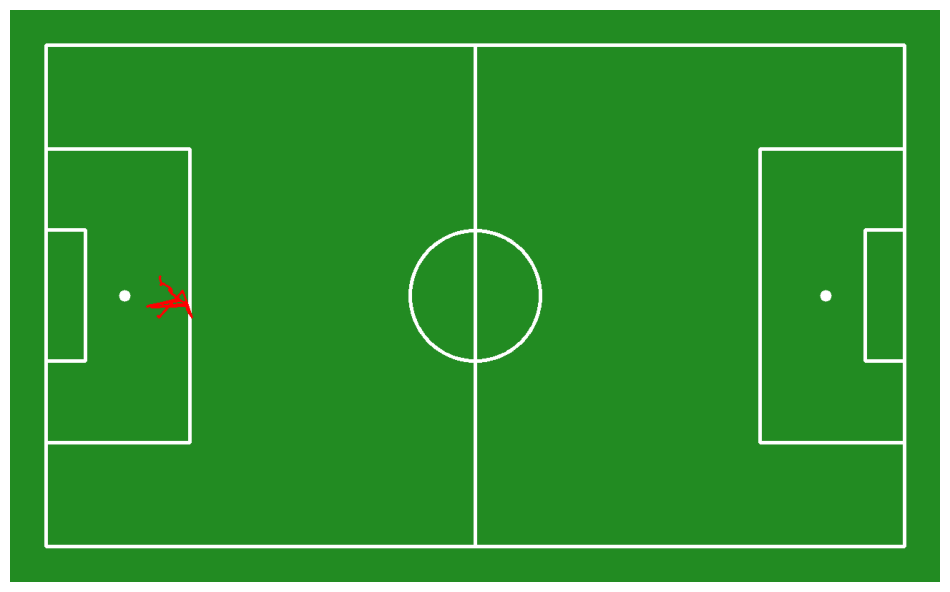

In [ ]:
from sports.annotators.soccer import draw_pitch, draw_paths_on_pitch

annotated_frame = draw_pitch(Config)
annotated_frame = draw_paths_on_pitch(
    config = Config,
    paths = [path],
    color = sv.Color.RED,
    pitch = annotated_frame
)

sv.plot_image(annotated_frame)


In [ ]:
from collections import deque
import numpy as np
from tqdm import tqdm


# Define IDs
Ball_id, Goalkeeper_id, Player_id, Referee_id = 0, 1, 2, 3
max_len = 5

# Initialize video processing
Source_video_path = "/content/input1.mp4"
video_info = sv.VideoInfo.from_video_path(Source_video_path)
frame_generator = sv.get_video_frames_generator(Source_video_path)

path_raw = []
M = deque(maxlen=max_len)

# Loop through video frames
for idx, frame in enumerate(tqdm(frame_generator, total=video_info.total_frames, desc='Processing', unit="frame", leave=True, ncols=80)):
    result = Player_detection_model.infer(frame, confidence=0.30)[0]
    detections = sv.Detections.from_inference(result)

    # Separate ball detections
    ball_detections = detections[detections.class_id == Ball_id]
    ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

    # Key point detection
    result_key_point = Key_point_detection_model.infer(frame, confidence=0.30)[0]
    key_points = sv.KeyPoints.from_inference(result_key_point)

    # Handle invalid key points
    filter_mask = key_points.confidence[0] > 0.5
    if not filter_mask.any():
        continue

    frame_reference_points = key_points.xy[0][filter_mask]
    pitch_reference_points = np.array(Config.vertices)[filter_mask]

    view_transformer = ViewTransformer(source=frame_reference_points, target=pitch_reference_points)

    # Store transformation matrix
    M.append(view_transformer.m)
    average_matrix = np.mean(np.array(M), axis=0)

    # Update transformer with smoothed matrix
    view_transformer = ViewTransformer(source=frame_reference_points, target=pitch_reference_points)
    view_transformer.m = average_matrix

    # Transform ball coordinates
    frame_ball_xy = ball_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    pitch_ball_xy = view_transformer.transform_points(frame_ball_xy)

    path_raw.append(pitch_ball_xy)

# Flatten and clean paths
path = [
    np.empty((0,2), dtype=np.float32) if coordinates.shape[0] < 2 else coordinates
    for coordinates in path_raw
]
path = [coordinates.flatten() for coordinates in path]

# Remove outliers
Max_distance_threshold = 500
path = replace_outliers_based_on_distance(path, Max_distance_threshold)

# Draw final annotated frame
annotated_frame = draw_pitch(Config)
annotated_frame = draw_paths_on_pitch(
    config=Config,
    paths=[path],  # Fixed nested list issue
    color=sv.Color.RED,
    pitch=annotated_frame
)

sv.plot_image(annotated_frame)


## Ball Tracking

In [ ]:
import torch
import cv2
import numpy as np
import supervision as sv
from tqdm import tqdm
from collections import deque
from sports.common.team import TeamClassifier
from sports.annotators.soccer import draw_pitch, draw_points_on_pitch

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Define class IDs
BALL_ID, GOALKEEPER_ID, PLAYER_ID, REFEREE_ID = 0, 1, 2, 3

# Video paths
source_video_path = "/content//input1.mp4"
target_video_path = "/content/Outputs/Ball_tracking2.mp4"
video_info = sv.VideoInfo.from_video_path(source_video_path)
video_sink = sv.VideoSink(target_path=target_video_path, video_info=video_info)

# Load models
tracker = sv.ByteTrack()
tracker.reset()

# Extract player crops for team classification

team_classifier = TeamClassifier(device=device)
team_classifier.fit(extract_player_crops(source_video_path))

# Initialize tracking variables
ball_trajectory_3d = deque(maxlen=150)
ball_trajectory_2d = deque(maxlen=150)
last_erase_time = 0

# Annotators
ellipse_annotator = sv.EllipseAnnotator(color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']), thickness=2)
triangle_annotator = sv.TriangleAnnotator(color=sv.ColorPalette.from_hex(['#FFD700']), base=20, height=17)
label_annotator = sv.LabelAnnotator(color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']), text_color=sv.ColorPalette.from_hex(['#000000']), text_position=sv.Position.BOTTOM_CENTER)

with video_sink:
    frame_generator = sv.get_video_frames_generator(source_video_path)
    for idx, frame in enumerate(tqdm(frame_generator, total=video_info.total_frames, desc='Processing', unit="frame", leave=False, ncols=80)):
        result = Player_detection_model.infer(frame, confidence=0.30)[0]
        detections = sv.Detections.from_inference(result)

        # Separate detections
        ball_detections = detections[detections.class_id == BALL_ID]
        all_detections = detections[detections.class_id != BALL_ID]

        # Track players
        if len(ball_detections.xyxy) > 0:
            ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)
        all_detections = tracker.update_with_detections(all_detections).with_nms(threshold=0.5, class_agnostic=True)

        # Classify players
        player_detections = all_detections[all_detections.class_id == PLAYER_ID]
        goalkeeper_detections = all_detections[all_detections.class_id == GOALKEEPER_ID]
        referee_detections = all_detections[all_detections.class_id == REFEREE_ID]

        if len(player_detections) > 0:
            player_crops = [sv.crop_image(frame, xyxy) for xyxy in player_detections.xyxy]
            player_detections.class_id = team_classifier.predict(player_crops)

        result_key_points = Key_point_detection_model.infer(frame, confidence=0.30)[0]
        key_points = sv.KeyPoints.from_inference(result_key_points)

        # Filter key points
        filter_mask = key_points.confidence[0] > 0.5
        frame_reference_points = key_points.xy[0][filter_mask] if filter_mask.any() else None
        pitch_reference_points = np.array(Config.vertices)[filter_mask] if filter_mask.any() else None

        # Ensure valid reference points
        if frame_reference_points is None or pitch_reference_points is None:
            raise ValueError("Key point detection failed. Check the model or input video.")

        # Initialize view transformer
        view_transformer = ViewTransformer(source=frame_reference_points, target=pitch_reference_points)


        # Get transformed coordinates
        def safe_transform(detections):
            if len(detections) > 0:
                frame_xy = detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
                return view_transformer.transform_points(frame_xy)
            return None

        pitch_players_xy = safe_transform(player_detections)
        pitch_ball_xy = safe_transform(ball_detections)
        pitch_goalkeepers_xy = safe_transform(goalkeeper_detections)
        pitch_referees_xy = safe_transform(referee_detections)



        # Draw pitch (Radar View)
        pitch = draw_pitch(Config)
        if pitch_ball_xy is not None:
            pitch = draw_points_on_pitch(config=Config, xy=pitch_ball_xy, face_color=sv.Color.BLACK, edge_color=sv.Color.BLACK, radius=25, pitch=pitch)

        if pitch_players_xy is not None:
            pitch = draw_points_on_pitch(config=Config, xy=pitch_players_xy[player_detections.class_id == 0], face_color=sv.Color.from_hex('#00BFFF'), edge_color=sv.Color.BLACK, radius=25, pitch=pitch)
            pitch = draw_points_on_pitch(config=Config, xy=pitch_players_xy[player_detections.class_id == 1], face_color=sv.Color.from_hex('#FF1493'), edge_color=sv.Color.BLACK, radius=25, pitch=pitch)

        if pitch_goalkeepers_xy is not None:
            pitch = draw_points_on_pitch(config=Config, xy=pitch_goalkeepers_xy[goalkeeper_detections.class_id == 0], face_color=sv.Color.from_hex('#00BFFF'), edge_color=sv.Color.BLACK, radius=25, pitch=pitch)
            pitch = draw_points_on_pitch(config=Config, xy=pitch_goalkeepers_xy[goalkeeper_detections.class_id == 1], face_color=sv.Color.from_hex('#FF1493'), edge_color=sv.Color.BLACK, radius=25, pitch=pitch)

        if pitch_referees_xy is not None:
            pitch = draw_points_on_pitch(config=Config, xy=pitch_referees_xy, face_color=sv.Color.YELLOW, edge_color=sv.Color.BLACK, radius=10, pitch=pitch)

        # Track Ball Movement
        if len(ball_detections.xyxy) == 1:
            ball_box = ball_detections.xyxy[0]
            ball_x = int((ball_box[0] + ball_box[2]) / 2)
            ball_y = int(ball_box[3])
            ball_center_3d = (ball_x, ball_y)

            if len(ball_trajectory_3d) > 0:
                last_x, last_y = ball_trajectory_3d[-1]
                if abs(ball_x - last_x) > 50 or abs(ball_y - last_y) > 50:
                    continue

            ball_trajectory_3d.append(ball_center_3d)
            if len(ball_trajectory_3d) > 50:
                ball_trajectory_3d.popleft()

        if len(ball_detections) > 0:
            ball_trajectory_2d.append(ball_detections.xyxy[0])

        # Erase ball path every second
        if idx - last_erase_time >= 75:
            ball_trajectory_3d.clear()
            ball_trajectory_2d.clear()
            last_erase_time = idx

        # Annotate frame
        referee_detections.class_id -= 1
        all_detections = sv.Detections.merge([player_detections, goalkeeper_detections, referee_detections])
        all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
        all_detections.class_id = all_detections.class_id.astype(int)
        annotated_frame = frame.copy()
        annotated_frame = ellipse_annotator.annotate(annotated_frame, all_detections)
        annotated_frame = triangle_annotator.annotate(annotated_frame, ball_detections)
        annotated_frame = label_annotator.annotate(annotated_frame, detections=all_detections, labels=[f"#{tid}" for tid in all_detections.tracker_id])

        if len(ball_trajectory_3d) > 1:
            trajectory_array = np.array(ball_trajectory_3d, dtype=np.int32).reshape(-1, 1, 2)
            cv2.polylines(annotated_frame, [trajectory_array], isClosed=False, color=(0, 0, 255), thickness=3)

        # Calculate radar view size as 1/4th of the frame
        h, w, _ = annotated_frame.shape
        radar_size = (550,350)  # Dynamically setting 1/4th of the frame size
        pitch_resized = cv2.resize(pitch, radar_size)

        # Position radar view at the top-right corner
        y_offset = h - radar_size[1] - 25
        x_offset = (w - radar_size[0]) // 2

        # Create a transparent overlay
        overlay = annotated_frame.copy()
        overlay[y_offset:y_offset + radar_size[1], x_offset:x_offset + radar_size[0]] = pitch_resized

        # Blend the overlay with transparency
        alpha = 0.8  # Adjust transparency (0 = fully transparent, 1 = opaque)
        cv2.addWeighted(overlay, alpha, annotated_frame, 1 - alpha, 0, annotated_frame)

        # Display and write frame

        video_sink.write_frame(annotated_frame)


## Final Output

In [ ]:
import numpy as np
import cv2
import supervision as sv
from tqdm import tqdm
from typing import List, Union
import numpy as np
import numpy as np
import cv2
import supervision as sv
from tqdm import tqdm
from collections import deque

# Store the entire ball trajectory persistently
ball_trajectory = deque(maxlen=50)  # Keep only the latest 50 positions

MAX_SPEED = 50  # Adjust based on video FPS & field size
SMOOTHING_WINDOW = 5  # Rolling median window size

def rolling_median_filter(trajectory, window_size):
    """Apply rolling median filter to smooth trajectory data."""
    trajectory_list = list(trajectory)  # Convert deque to list for slicing
    if len(trajectory_list) < window_size:
        return trajectory_list  # Not enough data for filtering

    filtered = []
    for i in range(len(trajectory_list)):
        start = max(0, i - window_size + 1)
        window = np.array(trajectory_list[start:i + 1])  # ✅ Fixed slicing issue
        median_point = np.median(window, axis=0)
        filtered.append(tuple(median_point.astype(int)))

    return filtered

with video_sink:
    frame_generator = sv.get_video_frames_generator(source_video_path)

    for idx, frame in enumerate(tqdm(frame_generator, total=video_info.total_frames, desc='Processing', unit="frame", leave=False, ncols=80)):
        result = Player_detection_model.infer(frame, confidence=0.30)[0]
        detections = sv.Detections.from_inference(result)

        # Separate detections
        ball_detections = detections[detections.class_id == BALL_ID]
        all_detections = detections[detections.class_id != BALL_ID]

        # Ball tracking logic
        if len(ball_detections) > 0:
            x1, y1, x2, y2 = ball_detections.xyxy[0]
            ball_center = np.array([(x1 + x2) / 2, (y1 + y2) / 2])

            # Ensure smooth tracking
            if len(ball_trajectory) == 0 or np.linalg.norm(ball_center - np.array(ball_trajectory[-1])) < MAX_SPEED:
                ball_trajectory.append(tuple(ball_center.astype(int)))

        # Apply rolling median filter
        filtered_trajectory = rolling_median_filter(ball_trajectory, SMOOTHING_WINDOW)

        # Update trajectory (ensure it doesn't get cleared)
        if filtered_trajectory:  # Prevent clearing if filtering fails
            ball_trajectory = deque(filtered_trajectory, maxlen=50)

        # Debugging: Print trajectory points
        print(f"Frame {idx}: {list(ball_trajectory)}")  # REMOVE THIS AFTER DEBUGGING

        # Use predefined annotators
        annotated_frame = ellipse_annotator.annotate(frame, all_detections)
        annotated_frame = triangle_annotator.annotate(annotated_frame, ball_detections)

        # Draw the entire ball trajectory
        if len(ball_trajectory) > 1:
            for i in range(1, len(ball_trajectory)):
                cv2.line(annotated_frame, ball_trajectory[i - 1], ball_trajectory[i], (0, 0, 255), 2)

        # Write processed frame
        video_sink.write_frame(annotated_frame)

## Wasted


In [ ]:
import torch
import cv2
import numpy as np
import supervision as sv
from tqdm import tqdm
from collections import deque
from sports.common.team import TeamClassifier
from sports.annotators.soccer import draw_pitch, draw_points_on_pitch

# Define class IDs
BALL_ID, GOALKEEPER_ID, PLAYER_ID, REFEREE_ID = 0, 1, 2, 3

# Initialize video processing
SOURCE_VIDEO_PATH = "/content/input1.mp4"
TARGET_VIDEO_PATH = "/content/Outputs/Ball_tracking.mp4"
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
video_sink = sv.VideoSink(target_path=TARGET_VIDEO_PATH, video_info=video_info)

# Define device
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"



# Load team classifier
crops = extract_player_crops(Source_video_path)
team_classifier = TeamClassifier(device=DEVICE)
team_classifier.fit(crops)


# Initialize tracker
tracker = sv.ByteTrack()
tracker.reset()

# Get video frames
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

# Tracking variables
ball_trajectory_3d = deque(maxlen=50)
ball_trajectory_2d = deque(maxlen=50)

# Annotators
ellipse_annotator = sv.EllipseAnnotator(color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']), thickness=2)
triangle_annotator = sv.TriangleAnnotator(color=sv.ColorPalette.from_hex(['#FFD700']), base=20, height=17)
label_annotator = sv.LabelAnnotator(color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']), text_color=sv.ColorPalette.from_hex(['#000000']), text_position=sv.Position.BOTTOM_CENTER)

with video_sink:
    for idx, frame in enumerate(tqdm(frame_generator, total=video_info.total_frames, desc='Processing', unit="frame", leave=False, ncols=80)):

        ball_position_3d = None
        ball_position_2d = None

        # Player detection
        result = Player_detection_model.infer(frame, confidence=0.30)[0]
        detections = sv.Detections.from_inference(result)

        # Separate detections
        ball_detections = detections[detections.class_id == BALL_ID]
        all_detections = detections[detections.class_id != BALL_ID]

        # Track players
        if len(ball_detections.xyxy) > 0:
            ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)
        all_detections = tracker.update_with_detections(all_detections).with_nms(threshold=0.5, class_agnostic=True)

        # Classify players
        player_detections = all_detections[all_detections.class_id == PLAYER_ID]
        goalkeeper_detections = all_detections[all_detections.class_id == GOALKEEPER_ID]
        referee_detections = all_detections[all_detections.class_id == REFEREE_ID]

        if len(player_detections) > 0:
            player_crops = [sv.crop_image(frame, xyxy) for xyxy in player_detections.xyxy]
            player_detections.class_id = team_classifier.predict(player_crops)

        # Key point detection
        result_key_points = Key_point_detection_model.infer(frame, confidence=0.30)[0]
        key_points = sv.KeyPoints.from_inference(result_key_points)

        # Filter key points
        filter_mask = key_points.confidence[0] > 0.5
        frame_reference_points = key_points.xy[0][filter_mask] if filter_mask.any() else None
        pitch_reference_points = np.array(Config.vertices)[filter_mask] if filter_mask.any() else None

        # Ensure valid reference points
        if frame_reference_points is None or pitch_reference_points is None:
            raise ValueError("Key point detection failed. Check the model or input video.")

        # Initialize view transformer
        view_transformer = ViewTransformer(source=frame_reference_points, target=pitch_reference_points)

        # Get transformed coordinates
        def safe_transform(detections):
            if len(detections) > 0:
                frame_xy = detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
                return view_transformer.transform_points(frame_xy)
            return None

        pitch_players_xy = safe_transform(player_detections)
        pitch_ball_xy = safe_transform(ball_detections)
        pitch_goalkeepers_xy = safe_transform(goalkeeper_detections)
        pitch_referees_xy = safe_transform(referee_detections)

        # Draw pitch (Radar View)
        pitch = draw_pitch(Config)
        if pitch_ball_xy is not None:
            pitch = draw_points_on_pitch(config=Config, xy=pitch_ball_xy, face_color=sv.Color.BLACK, edge_color=sv.Color.BLACK, radius=25, pitch=pitch)

        if pitch_players_xy is not None:
            pitch = draw_points_on_pitch(config=Config, xy=pitch_players_xy[player_detections.class_id == 0], face_color=sv.Color.from_hex('#00BFFF'), edge_color=sv.Color.BLACK, radius=25, pitch=pitch)
            pitch = draw_points_on_pitch(config=Config, xy=pitch_players_xy[player_detections.class_id == 1], face_color=sv.Color.from_hex('#FF1493'), edge_color=sv.Color.BLACK, radius=25, pitch=pitch)

        if pitch_goalkeepers_xy is not None:
            pitch = draw_points_on_pitch(config=Config, xy=pitch_goalkeepers_xy, face_color=sv.Color.from_hex('#FFD700'), edge_color=sv.Color.BLACK, radius=25, pitch=pitch)

        if pitch_referees_xy is not None:
            pitch = draw_points_on_pitch(config=Config, xy=pitch_referees_xy, face_color=sv.Color.YELLOW, edge_color=sv.Color.BLACK, radius=10, pitch=pitch)

        # Track Ball Movement
        if len(ball_detections.xyxy) == 1:
            ball_box = ball_detections.xyxy[0]
            ball_x = int((ball_box[0] + ball_box[2]) / 2)
            ball_y = int(ball_box[3])
            ball_position_3d = (ball_x, ball_y)  # Define ball_position_3d

            if len(ball_trajectory_3d) > 0:
                last_x, last_y = ball_trajectory_3d[-1]
                if abs(ball_x - last_x) > 50 or abs(ball_y - last_y) > 50:
                    pass  # Ignore large jumps

            ball_trajectory_3d.append(ball_position_3d)

        if len(ball_detections) > 0:
            ball_position_2d = ball_detections.xyxy[0]  # Define ball_position_2d
            ball_trajectory_2d.append(ball_position_2d)



        if ball_position_3d is not None:
            ball_trajectory_3d.append(ball_position_3d)  # Add new position
            ball_trajectory_3d.popleft()  # Remove oldest position

        if ball_position_2d is not None:
            ball_trajectory_2d.append(ball_position_2d)  # Add new position
            ball_trajectory_2d.popleft()


        # Annotate frame
        annotated_frame = frame.copy()
        annotated_frame = ellipse_annotator.annotate(annotated_frame, all_detections)
        annotated_frame = triangle_annotator.annotate(annotated_frame, ball_detections)
        annotated_frame = label_annotator.annotate(annotated_frame, detections=all_detections, labels=[f"#{tid}" for tid in all_detections.tracker_id])

        if len(ball_trajectory_3d) > 1:
            trajectory_array = np.array(ball_trajectory_3d, dtype=np.int32).reshape(-1, 1, 2)
            cv2.polylines(annotated_frame, [trajectory_array], isClosed=False, color=(0, 0, 255), thickness=3)

        # Calculate radar view size as 1/4th of the frame
        h, w, _ = annotated_frame.shape
        radar_size = (500,300)  # Dynamically setting 1/4th of the frame size
        pitch_resized = cv2.resize(pitch, radar_size)

        # Position radar view at the top-right corner
        y_offset = h - radar_size[1] - 25
        x_offset = (w - radar_size[0]) // 2

        # Create a transparent overlay
        overlay = annotated_frame.copy()
        overlay[y_offset:y_offset + radar_size[1], x_offset:x_offset + radar_size[0]] = pitch_resized

        # Blend the overlay with transparency
        alpha = 0.85  # Adjust transparency (0 = fully transparent, 1 = opaque)
        cv2.addWeighted(overlay, alpha, annotated_frame, 1 - alpha, 0, annotated_frame)

        # Display and write frame
        video_sink.write_frame(annotated_frame)
